# Environment Developer

## The following cells need to become part of the Python-library

In [1]:
from gym import Env
from gym.spaces import Box
import numpy as np
import pandas as pd
     

In [2]:
class ContinuousTrading(Env):

# This environment is based on returns, i.e.:
# The first column in the data frame must be returns and not prices
# States are defined by means of all cells (columns) in a particular row (where rows 
# represent points in time)


    def __init__(self,
                 df,
                 initial_investment = 100,
                 interest_rate = 0.00,
                 transaction_cost_pct=0.00):
        
           
        # In the beginning we might just check whether the input data is correct
        assert df.ndim == 2, "Only 2D data frames are supported."
        assert df.empty == False, "The Data Frame seems empty."
        
        # Put the input data into instance-variables
        self.data = df.values  # This are the data in the whole dataframe
        self.ret = df.iloc[:, 0].values # This is the first column in the data frame
        
        self.initial_investment = initial_investment
        self.interest_rate = interest_rate
        self.transaction_cost_pct = transaction_cost_pct
        
        # In what follows we create the observation space
        # Here we use the minimum and maximimum values in the data frame
        # Here we increase the max by a little (e.g. 0.01 for returns and 1 for prices) such that a new bin does not start exactly on the max value
        # Otherwise the Q-Learning algorithm gives an error
               
        max_values = np.array(df.max())
        max_values = max_values + 0.01     #
        min_values = np.array(df.min())
        
        self.observation_space = Box(low=min_values, high=max_values, dtype=np.float32)
        
        # Action Space
        
        self.action_space = Box(low = np.array([0]), high = np.array([1]), dtype=np.float32) # How much of total asset wealth into the
        
        self.time = None
        
        
    def reset(self):
        
        self.time = 0
        self.StockValue_Out = 0.00
        self.BankValue_Out = self.initial_investment
        self.reward = 0.00
        self.Wealth_Out = self.BankValue_Out + self.StockValue_Out
        
        self.state = self.data[self.time,:]
        self.state = np.float32(self.state)
       
        return self.state
    
    
    def render(self):
        # Implement visualization if needed
        pass   
    
    
    def step(self, action):
        # The following actions apply
        # 0 means sell or stay out
        # 1 means buy or hold
        
        
        self.BankValue_In = self.BankValue_Out
        self.StockValue_In = self.StockValue_Out
        self.Wealth_In = self.Wealth_Out
        
        self.StockReturn = self.data[self.time + 1 ,0]  # The stock return achieved in point t+1 
                                                        # when buying the stock at point t
            
            
        if action == 0:
            # We sell all crypto currency
            self.delta_Stock = -self.StockValue_In 
        else:    
            # The change in stock investment (which can be positive or negative):
            self.delta_Stock = self.BankValue_In - (( 1/action - 1) * self.StockValue_In) / (1/action + self.transaction_cost_pct)
                    
        
        self.StockValue_Out = (self.StockValue_In + self.delta_Stock) * (1 + self.StockReturn)
        self.BankValue_Out = (self.BankValue_In - self.delta_Stock * (1 + self.transaction_cost_pct)) * (1 + self.interest_rate)
        
        self.Wealth_Out = self.BankValue_Out + self.StockValue_Out
        self.time = self.time + 1
        
        self.state = self.data[self.time,:]
        self.state = np.float32(self.state)
        
        self.reward = self.Wealth_Out - self.Wealth_In
        self.reward = float(self.reward)
        
              
        if self.time == len(self.ret) - 1:
            done = True
        else:
            done = False
        
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, self.reward, done, info           

   
    
    
    

# Environment Testing

## The following cells are NOT part of the Python-library

In [3]:
import matplotlib.pyplot as plt

### Load Data

In [4]:
path = '0030_Det_Return_Sine.xlsx'
df = pd.read_excel(path)
df.head()

,Return
0,0.002998
1,0.003987
2,0.004955
3,0.005894
4,0.006794


### Load Environment Above

In [5]:
env = ContinuousTrading(df, 100, 0.00, 0.00)

C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


### Load Environment fro Library

In [27]:
from TradingEnvironments import ContinuousTrading
env = ContinuousTrading(df, 100, 0.00, 0.00)

C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## Environment Checker

In [28]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


### Observation Spase and Random Observation

In [29]:
print('The observations space is:', env.observation_space)
obs = env.observation_space.sample()
print('Some random observation:', obs)

The observations space is: Box([-0.0079999], [0.02199574], (1,), float32)
Some random observation: [0.01536583]


### Action Space and Random Action

In [30]:
print('The action space is:', env.action_space)
action = env.action_space.sample()
print('Some random action:', action)

The action space is: Box([0.], [1.], (1,), float32)
Some random action: [0.96089864]


### Run Environment for some Random Actions

In [31]:
obs = env.reset()
done = False

i = 0
tot_reward = 0

i_list = []
action_list = []
reward_list = []
tot_reward_list = []

while not done:
    i = i + 1
    i_list.append(i)
        
    action = env.action_space.sample()
    action_list.append(action)
    
    obs, reward, done, info = env.step(action)
    reward_list.append(reward)

    tot_reward = tot_reward + reward
    tot_reward_list.append( tot_reward)


Text(0.5, 1.0, 'Total reward')

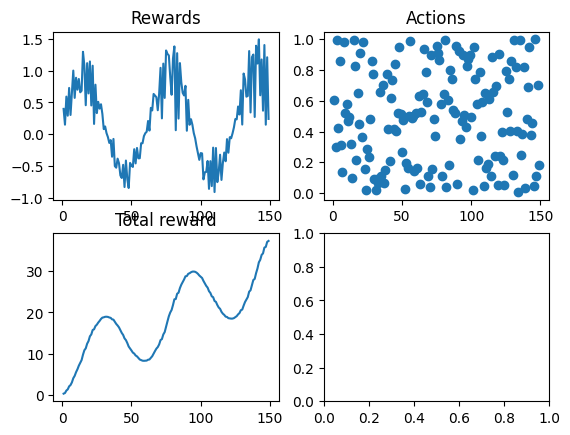

In [32]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(i_list, reward_list)
axs[0, 0].set_title('Rewards')
axs[0, 1].scatter(i_list, action_list)
axs[0, 1].set_title('Actions')
axs[1, 0].plot(i_list, tot_reward_list)
axs[1, 0].set_title('Total reward')

### Run Environment for some Given Actions

In [38]:
obs = env.reset()
done = False

i = 0
tot_reward = 0

i_list = []
action_list = []
reward_list = []
tot_reward_list = []


while not done:
    i = i + 1
    i_list.append(i)
        
    action = 0.5
    action_list.append(action)
    
    obs, reward, done, info = env.step(action)
    reward_list.append(reward)

    tot_reward = tot_reward + reward
    tot_reward_list.append( tot_reward)

Text(0.5, 1.0, 'Total reward')

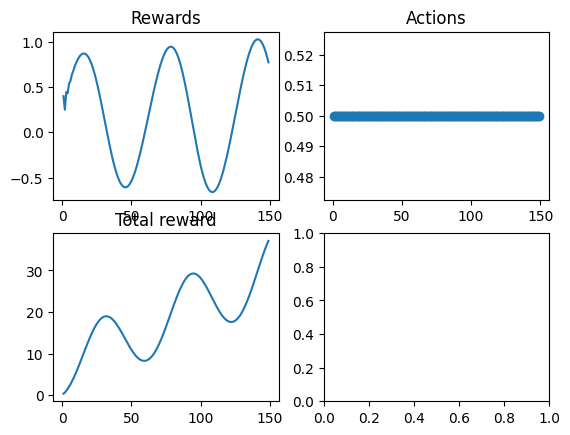

In [39]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(i_list, reward_list)
axs[0, 0].set_title('Rewards')
axs[0, 1].scatter(i_list, action_list)
axs[0, 1].set_title('Actions')
axs[1, 0].plot(i_list, tot_reward_list)
axs[1, 0].set_title('Total reward')